## **Visualisation des parcelles dédiées à l'agriculture biologique en France** 

In [1]:
!pip install chardet 

In [2]:
import requests
import zipfile
import os
import pandas as pd

# URL du fichier ZIP
url_zip = "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29"

# Chemin pour stocker temporairement le fichier ZIP
zip_path = "data.zip"

# Télécharger le fichier ZIP
response = requests.get(url_zip)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Extraire le contenu du fichier ZIP
extract_path = "data_extracted"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Identifier les fichiers extraits
files = os.listdir(extract_path)
print("Fichiers extraits :", files)

# Charger un fichier CSV ou SHP à partir des fichiers extraits
for file in files:
    if file.endswith(".csv"):
        csv_path = os.path.join(extract_path, file)
        df = pd.read_csv(csv_path)
        print("Aperçu du fichier CSV chargé :")
        print(df.head())
    elif file.endswith(".shp"):
        import geopandas as gpd
        shp_path = os.path.join(extract_path, file)
        gdf = gpd.read_file(shp_path)
        print("Aperçu du fichier SHP chargé :")
        print(gdf.head())


Fichiers extraits : ['rpg-bio-2023-national']


In [5]:
import requests
import zipfile
import os
import pandas as pd

# URL du fichier ZIP
url_zip = "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29"

# Chemin pour stocker temporairement le fichier ZIP
zip_path = "data.zip"

# Télécharger le fichier ZIP
response = requests.get(url_zip)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Extraire le contenu du fichier ZIP
extract_path = "data_extracted"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Identifier les fichiers extraits (y compris sous-dossiers)
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            df = pd.read_csv(csv_path)
            print("Aperçu du fichier CSV chargé :")
            print(df.head())
        elif file.endswith(".shp"):
            import geopandas as gpd
            shp_path = os.path.join(root, file)
            gdf = gpd.read_file(shp_path)
            print("Aperçu du fichier SHP chargé :")
            print(gdf.head())


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: data_extracted/rpg-bio-2023-national/rpg-bio-2023-national.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Aperçu du fichier SHP chargé :
       gid  millesime code_cultu precision_  \
0  1057718       2023        SPH       None   
1  1057720       2023        MCR        001   
2  1057733       2023        LUZ        002   
3  1045691       2023        SPH       None   
4  1063649       2023        MLG        001   

                                          lbl_cultur         grp_cultur  \
0  Prairie avec herbe prédominante et ressources ...  Estives et landes   
1  Mélange de céréales ou pseudo-céréales d'hiver...    Autres céréales   
2                                      Autre luzerne           Fourrage   
3  Prairie avec herbe prédominante et ressources ...  Estives et landes   
4  Mélange de légumineuses prépondérantes et de g...           Fourrage   

   surface_ha code_commu         lbl_commun    code_epci code_depar  \
0        0.56      12294  Vézins-de-Lévézou  241200765.0         12   
1        2.22      12294  Vézins-de-Lévézou  241200765.0         12   
2        1.28      123

In [7]:
# Créer une nouvelle variable en supprimant la colonne 'geometry'
gdf_filtered = gdf.drop(columns=['geometry'])

# Afficher les premières lignes pour vérifier
print("Aperçu des données sans la colonne 'geometry' :")
print(gdf_filtered.head())


Aperçu des données sans la colonne 'geometry' :
       gid  millesime code_cultu precision_  \
0  1057718       2023        SPH       None   
1  1057720       2023        MCR        001   
2  1057733       2023        LUZ        002   
3  1045691       2023        SPH       None   
4  1063649       2023        MLG        001   

                                          lbl_cultur         grp_cultur  \
0  Prairie avec herbe prédominante et ressources ...  Estives et landes   
1  Mélange de céréales ou pseudo-céréales d'hiver...    Autres céréales   
2                                      Autre luzerne           Fourrage   
3  Prairie avec herbe prédominante et ressources ...  Estives et landes   
4  Mélange de légumineuses prépondérantes et de g...           Fourrage   

   surface_ha code_commu         lbl_commun    code_epci code_depar  \
0        0.56      12294  Vézins-de-Lévézou  241200765.0         12   
1        2.22      12294  Vézins-de-Lévézou  241200765.0         12   
2    

Départements avec le plus de parcelles biologiques :
   code_departement  nombre_parcelles  surface_totale_ha
2                32             36484          115319.18
58               65              7900          103096.45
1                44             39764           87245.72
4                12             31583           77857.75
3                11             32074           68744.30
..              ...               ...                ...
92              972               679             626.78
96              976               102              73.61
98               93                24              60.55
97               94                39              54.30
99              978                 4              44.83

[100 rows x 3 columns]


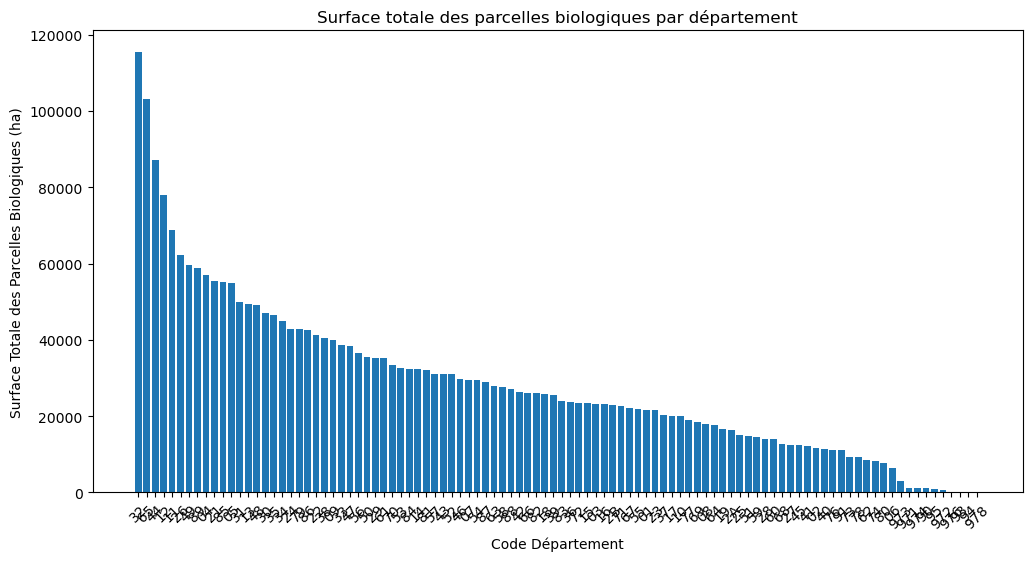

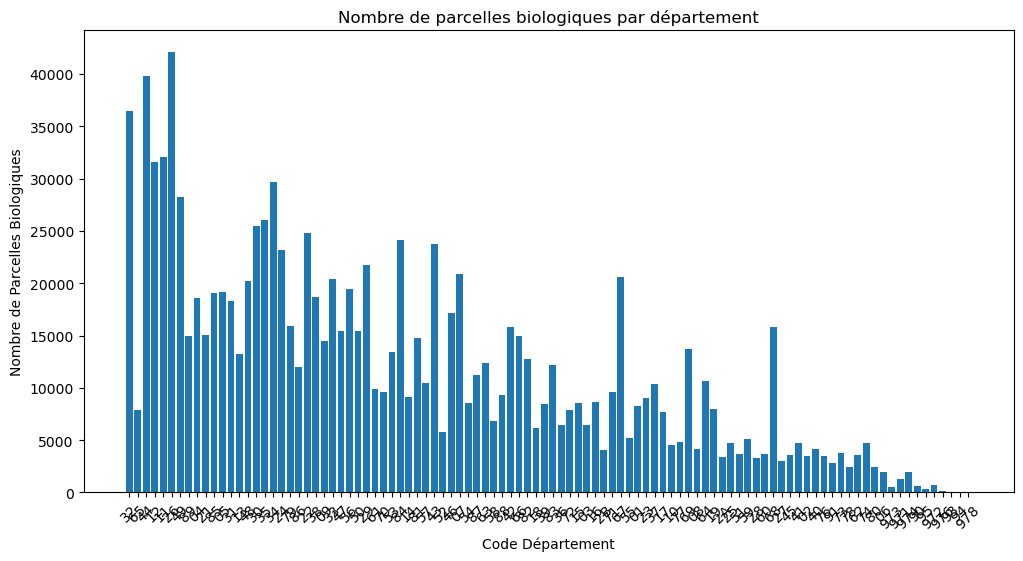

In [8]:
import matplotlib.pyplot as plt

# Étape 1 : Compter le nombre de parcelles biologiques par département
parcelles_par_departement = gdf_filtered['code_depar'].value_counts().reset_index()
parcelles_par_departement.columns = ['code_departement', 'nombre_parcelles']

# Étape 2 : Agréger la surface totale des parcelles biologiques par département
surface_par_departement = gdf_filtered.groupby('code_depar')['surface_ha'].sum().reset_index()
surface_par_departement.columns = ['code_departement', 'surface_totale_ha']

# Fusionner les deux DataFrames pour avoir les deux informations
resultat = parcelles_par_departement.merge(surface_par_departement, on='code_departement')

# Trier les départements par surface totale (ou nombre de parcelles si préféré)
resultat = resultat.sort_values(by='surface_totale_ha', ascending=False)

# Afficher les résultats
print("Départements avec le plus de parcelles biologiques :")
print(resultat)

# Étape 3 : Visualiser les résultats avec un graphique
plt.figure(figsize=(12, 6))
plt.bar(resultat['code_departement'], resultat['surface_totale_ha'])
plt.xlabel('Code Département')
plt.ylabel('Surface Totale des Parcelles Biologiques (ha)')
plt.title('Surface totale des parcelles biologiques par département')
plt.xticks(rotation=45)
plt.show()

# Optionnel : Visualisation du nombre de parcelles
plt.figure(figsize=(12, 6))
plt.bar(resultat['code_departement'], resultat['nombre_parcelles'])
plt.xlabel('Code Département')
plt.ylabel('Nombre de Parcelles Biologiques')
plt.title('Nombre de parcelles biologiques par département')
plt.xticks(rotation=45)
plt.show()


In [12]:
# Dictionnaire code_region -> nom de la région (métropole)
region_mapping = {
    '11': 'Île-de-France',
    '24': 'Centre-Val de Loire',
    '27': 'Bourgogne-Franche-Comté',
    '28': 'Normandie',
    '32': 'Hauts-de-France',
    '44': 'Grand Est',
    '52': 'Pays de la Loire',
    '53': 'Bretagne',
    '75': 'Nouvelle-Aquitaine',
    '76': 'Occitanie',
    '84': 'Auvergne-Rhône-Alpes',
    '93': 'Provence-Alpes-Côte d\'Azur',
    '94': 'Corse'
}

# Filtrer le DataFrame pour ne garder que les codes régions métropolitaines
gdf_filtered = gdf_filtered[gdf_filtered['code_regio'].astype(str).isin(region_mapping.keys())]

# Créer une colonne nom_region à partir des codes
gdf_filtered['nom_region'] = gdf_filtered['code_regio'].astype(str).map(region_mapping)

# Vérification
print(gdf_filtered[['code_regio', 'nom_region']].drop_duplicates())


        code_regio                  nom_region
0               76                   Occitanie
54              93  Provence-Alpes-Côte d'Azur
183             27     Bourgogne-Franche-Comté
217             75          Nouvelle-Aquitaine
849             28                   Normandie
858             84        Auvergne-Rhône-Alpes
1694            24         Centre-Val de Loire
13073           53                    Bretagne
27685           44                   Grand Est
76926           11               Île-de-France
79321           94                       Corse
141334          52            Pays de la Loire
248525          32             Hauts-de-France


/tmp/ipykernel_63397/2515751324.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_filtered['nom_region'] = gdf_filtered['code_regio'].astype(str).map(region_mapping)


In [13]:
gdf_filtered.head()

,gid,millesime,code_cultu,precision_,lbl_cultur,grp_cultur,surface_ha,code_commu,lbl_commun,code_epci,code_depar,code_regio,zone_geo,nom_region
0,1057718,2023,SPH,None,Prairie avec herbe prédominante et ressources ...,Estives et landes,0.56,12294,Vézins-de-Lévézou,241200765.0,12,76,France mét.,Occitanie
1,1057720,2023,MCR,001,Mélange de céréales ou pseudo-céréales d'hiver...,Autres céréales,2.22,12294,Vézins-de-Lévézou,241200765.0,12,76,France mét.,Occitanie
2,1057733,2023,LUZ,002,Autre luzerne,Fourrage,1.28,12303,Vimenet,200068484.0,12,76,France mét.,Occitanie
3,1045691,2023,SPH,None,Prairie avec herbe prédominante et ressources ...,Estives et landes,10.78,12145,Millau,241200567.0,12,76,France mét.,Occitanie
4,1063649,2023,MLG,001,Mélange de légumineuses prépondérantes et de g...,Fourrage,2.77,12059,Castanet,200068831.0,12,76,France mét.,Occitanie


In [16]:
gdf_filtered.columns

Index(['gid', 'millesime', 'code_cultu', 'precision_', 'lbl_cultur',
       'grp_cultur', 'surface_ha', 'code_commu', 'lbl_commun', 'code_epci',
       'code_depar', 'code_regio', 'zone_geo', 'nom_region'],
      dtype='object')

In [18]:
gdf_counts = gdf_filtered.groupby('nom_region').size().reset_index(name='nb_parcelles_bio')
gdf_merged = gdf_france.merge(gdf_counts, left_on='nom', right_on='nom_region', how='left')



In [26]:
# Si code_regio est de type int
metropolitan_codes = [11,24,27,28,32,44,52,53,75,76,84,93,94]
gdf_metropole = gdf_filtered[gdf_filtered['code_regio'].isin(metropolitan_codes)]
print(gdf_filtered['code_regio'].unique())
total_metropole = len(gdf_metropole)
print(total_metropole)

[76 93 27 75 28 84 24 53 44 11 94 52 32]
1160919


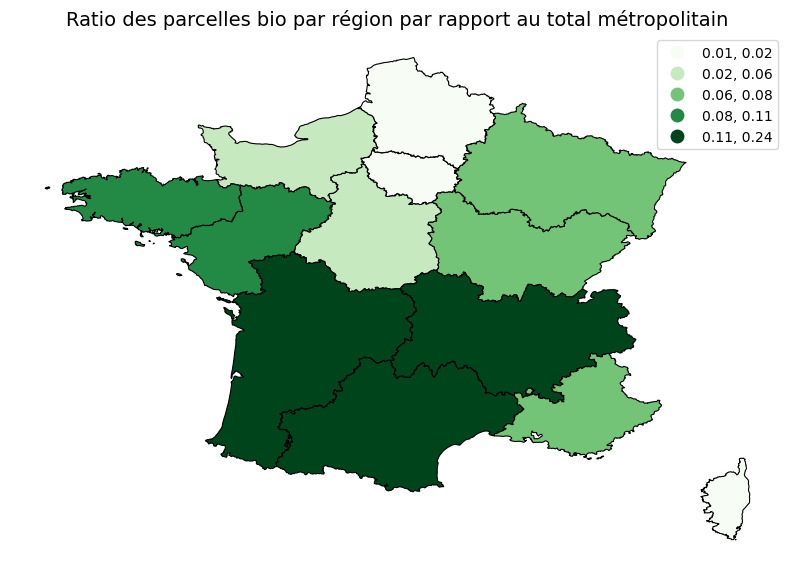

In [33]:
gdf_counts['ratio_parcelles_bio'] = gdf_counts['nb_parcelles_bio'] / total_metropole
gdf_merged = gdf_france.merge(gdf_counts, left_on='nom', right_on='nom_region', how='left')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
gdf_merged.plot(
    column='ratio_parcelles_bio',
    cmap='Greens',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    scheme='quantiles',  # Vous pouvez aussi utiliser 'user_defined' ou 'NaturalBreaks'
    k=5,
    ax=ax
)

ax.set_title("Ratio des parcelles bio par région par rapport au total métropolitain", fontdict={'fontsize': 14})
ax.axis('off')
plt.show()



Visualisation sur la carte de la France métropolitaine (départementale)

In [28]:
# 1. Charger la carte des départements
dept_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
gdf_departements = gpd.read_file(dept_url)

In [29]:
# Liste des codes à exclure (DOM-TOM) : 971, 972, 973, 974, 976, etc.
overseas_codes = ['971', '972', '973', '974', '976']
gdf_metropole = gdf_filtered[~gdf_filtered['code_depar'].isin(overseas_codes)]


In [30]:
# 4. Grouper par département pour obtenir le nombre de parcelles par département
df_dep = gdf_metropole.groupby('code_depar').size().reset_index(name='nb_parcelles_bio')

# 5. Calculer le ratio
df_dep['ratio'] = df_dep['nb_parcelles_bio'] / total_metropole * 100

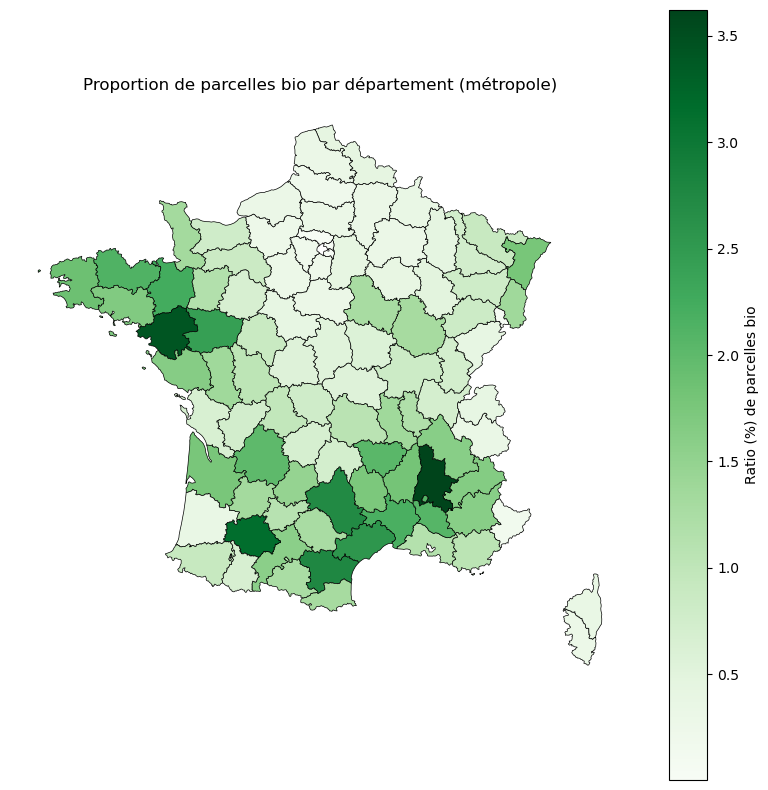

In [31]:
gdf_dep_final = gdf_departements.merge(df_dep, how='left', left_on='code', right_on='code_depar')

# 7. Visualiser la carte
fig, ax = plt.subplots(figsize=(10,10))
gdf_dep_final.plot(column='ratio', 
                   cmap='Greens', 
                   legend=True,
                   legend_kwds={'label': "Ratio (%) de parcelles bio"},
                   ax=ax,
                   edgecolor='black',
                   linewidth=0.5)

ax.set_title("Proportion de parcelles bio par département (métropole)")
ax.axis('off')
plt.show()